# Practical Task: Understanding and Applying Markov Decision Processes (MDPs)

This notebook implements the practical task for understanding MDPs in Reinforcement Learning.

## Objectives
- Understand the core components of MDPs
- Implement a simple 3×3 grid world MDP environment
- Implement Value Iteration algorithm
- Create and test policies
- Visualize agent behavior


## Part 1: Theory Review and Setup

### Core Components of MDPs:
- **States (S)**: 9 cells of the 3×3 grid
- **Actions (A)**: {UP, DOWN, LEFT, RIGHT}
- **Transition Probabilities (P)**: 80% chance of moving in intended direction, 20% random
- **Rewards (R)**: +10 for goal, -5 for danger zone, 0 otherwise
- **Discount factor (γ)**: 0.9

### Bellman Equation:
$$V(s) = \max_{a \in \mathcal{A}(s)} \sum_{s'} P(s'|s, a) [R(s,a,s') + \gamma V(s')]$$


### Environment Setup


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Tuple, Dict, List, Optional

# Set random seed for reproducibility
random.seed(0)
np.random.seed(0)

# Set plotting style
plt.style.use('default')
%matplotlib inline


## Part 2: Implementing a Simple MDP

### 2.1 Define the GridWorldMDP Class


In [2]:
class GridWorldMDP:
    """
    A 3x3 grid world MDP environment.

    States: 9 cells of the grid (0,0) to (2,2)
    Actions: {UP, DOWN, LEFT, RIGHT}
    Transition Probabilities: 80% intended direction, 20% random direction
    Rewards: +10 for goal, -5 for danger zone, 0 otherwise
    Discount factor: 0.9
    """

    def __init__(self, grid_size=3, goal_state=(2, 2), danger_state=(1, 1)):
        self.grid_size = grid_size
        self.goal_state = goal_state
        self.danger_state = danger_state
        self.states = [(i, j) for i in range(grid_size) for j in range(grid_size)]
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        self.reward_map = self.create_reward_map()
        self.transition_prob = 0.8  # 80% chance of intended action
        self.discount_factor = 0.9

    def create_reward_map(self):
        """Initialize the grid with rewards for goal and danger states."""
        reward_map = np.zeros((self.grid_size, self.grid_size))
        reward_map[self.goal_state] = 10
        reward_map[self.danger_state] = -5
        return reward_map

    def is_valid_state(self, state):
        """Check if a state is within the grid boundaries."""
        x, y = state
        return 0 <= x < self.grid_size and 0 <= y < self.grid_size

    def get_next_state(self, state, action):
        """Compute the next state based on the action taken."""
        x, y = state
        if action == 'UP':
            next_state = (x - 1, y)
        elif action == 'DOWN':
            next_state = (x + 1, y)
        elif action == 'LEFT':
            next_state = (x, y - 1)
        elif action == 'RIGHT':
            next_state = (x, y + 1)
        else:
            next_state = state

        return next_state if self.is_valid_state(next_state) else state

    def step(self, state, action):
        """
        Simulate one step in the environment:
        - 80% chance of following the intended action.
        - 20% chance of transitioning randomly.
        """
        if random.random() < self.transition_prob:
            next_state = self.get_next_state(state, action)
        else:
            rand_action = random.choice(self.actions)
            next_state = self.get_next_state(state, rand_action)

        reward = self.reward_map[next_state]
        done = (next_state == self.goal_state)
        return next_state, reward, done

    def get_transition_probabilities(self, state, action):
        """
        Get all possible next states and their probabilities for a given state-action pair.
        Returns: Dict mapping next_state -> probability
        """
        probs = {}

        # 80% chance: intended action
        intended_next = self.get_next_state(state, action)
        probs[intended_next] = probs.get(intended_next, 0) + self.transition_prob

        # 20% chance: random action (split equally among all actions)
        random_prob = (1 - self.transition_prob) / len(self.actions)
        for rand_action in self.actions:
            random_next = self.get_next_state(state, rand_action)
            probs[random_next] = probs.get(random_next, 0) + random_prob

        return probs

    def get_reward(self, state, action, next_state):
        """Get reward for transitioning from state to next_state via action."""
        return self.reward_map[next_state]


### 2.2 Create and Inspect the Environment


In [3]:
# Create the environment
env = GridWorldMDP()

print("=" * 60)
print("Grid World MDP Environment")
print("=" * 60)
print(f"Grid size: {env.grid_size}x{env.grid_size}")
print(f"Goal state: {env.goal_state} (reward: +10)")
print(f"Danger state: {env.danger_state} (reward: -5)")
print(f"Transition probability: {env.transition_prob} (80% intended, 20% random)")
print(f"Discount factor: {env.discount_factor}")
print(f"Number of states: {len(env.states)}")
print(f"Actions: {env.actions}")
print("=" * 60)


Grid World MDP Environment
Grid size: 3x3
Goal state: (2, 2) (reward: +10)
Danger state: (1, 1) (reward: -5)
Transition probability: 0.8 (80% intended, 20% random)
Discount factor: 0.9
Number of states: 9
Actions: ['UP', 'DOWN', 'LEFT', 'RIGHT']


### 2.3 Visualization Functions


In [4]:
def visualize_grid(env: GridWorldMDP, values: Optional[Dict] = None,
                   policy: Optional[Dict] = None, title: str = "Grid World"):
    """
    Visualize the grid world with values and/or policy.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Create grid
    grid = np.zeros((env.grid_size, env.grid_size))

    # Fill in values if provided
    if values:
        for (i, j), v in values.items():
            grid[i, j] = v

    # Create heatmap
    im = ax.imshow(grid, cmap='RdYlGn', aspect='auto', vmin=-5, vmax=10)

    # Add grid lines
    ax.set_xticks(np.arange(-0.5, env.grid_size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.grid_size, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    # Add text annotations
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            state = (i, j)
            text = ''

            # Add value if provided
            if values and state in values:
                text += f'{values[state]:.2f}\n'

            # Add policy arrow if provided
            if policy and state in policy:
                action = policy[state]
                arrows = {'UP': '↑', 'DOWN': '↓', 'LEFT': '←', 'RIGHT': '→'}
                text += arrows.get(action, '?')

            # Color coding
            if state == env.goal_state:
                bg_color = 'green'
                text = 'GOAL\n+10' if not values else f'{values[state]:.2f}\nGOAL'
            elif state == env.danger_state:
                bg_color = 'red'
                text = 'DANGER\n-5' if not values else f'{values[state]:.2f}\nDANGER'
            else:
                bg_color = 'white'

            # Add background rectangle
            rect = patches.Rectangle((j-0.5, i-0.5), 1, 1,
                                   linewidth=2, edgecolor='black',
                                   facecolor=bg_color, alpha=0.3)
            ax.add_patch(rect)

            # Add text
            ax.text(j, i, text, ha='center', va='center',
                   fontsize=12, color='black', weight='bold')

    plt.colorbar(im, ax=ax, label='Value')
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_xticks(range(env.grid_size))
    ax.set_yticks(range(env.grid_size))
    plt.tight_layout()
    plt.show()


def visualize_trajectory(env: GridWorldMDP, trajectory: List[Tuple]):
    """
    Visualize the agent's trajectory through the grid world.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Create grid background
    grid = np.zeros((env.grid_size, env.grid_size))
    im = ax.imshow(grid, cmap='gray', aspect='auto', alpha=0.3)

    # Add grid lines
    ax.set_xticks(np.arange(-0.5, env.grid_size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.grid_size, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    # Mark special states
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            state = (i, j)
            if state == env.goal_state:
                rect = patches.Rectangle((j-0.5, i-0.5), 1, 1,
                                       linewidth=2, edgecolor='black',
                                       facecolor='green', alpha=0.5)
                ax.add_patch(rect)
                ax.text(j, i, 'GOAL', ha='center', va='center',
                       fontsize=12, color='white', weight='bold')
            elif state == env.danger_state:
                rect = patches.Rectangle((j-0.5, i-0.5), 1, 1,
                                       linewidth=2, edgecolor='black',
                                       facecolor='red', alpha=0.5)
                ax.add_patch(rect)
                ax.text(j, i, 'DANGER', ha='center', va='center',
                       fontsize=10, color='white', weight='bold')

    # Draw trajectory
    if trajectory:
        states = [state for state, _, _ in trajectory]
        # Add final state (next state after last action)
        if trajectory:
            last_state, last_action, _ = trajectory[-1]
            final_state = env.get_next_state(last_state, last_action)
            states.append(final_state)

        # Draw path
        for idx in range(len(states) - 1):
            start = states[idx]
            end = states[idx + 1]

            # Draw arrow
            dx = end[1] - start[1]
            dy = end[0] - start[0]

            ax.arrow(start[1], start[0], dx * 0.7, dy * 0.7,
                    head_width=0.15, head_length=0.15,
                    fc='blue', ec='blue', linewidth=2, alpha=0.7)

        # Mark start state
        start_state = states[0]
        circle = patches.Circle((start_state[1], start_state[0]), 0.2,
                               color='blue', zorder=5)
        ax.add_patch(circle)
        ax.text(start_state[1], start_state[0] - 0.4, 'START',
               ha='center', va='top', fontsize=10, color='blue', weight='bold')

        # Mark visited states
        for state in states[:-1]:  # Exclude final state
            circle = patches.Circle((state[1], state[0]), 0.1,
                                   color='blue', alpha=0.5, zorder=4)
            ax.add_patch(circle)

    ax.set_title('Agent Trajectory', fontsize=14, weight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_xticks(range(env.grid_size))
    ax.set_yticks(range(env.grid_size))
    plt.tight_layout()
    plt.show()


### 2.4 Visualize the Grid World


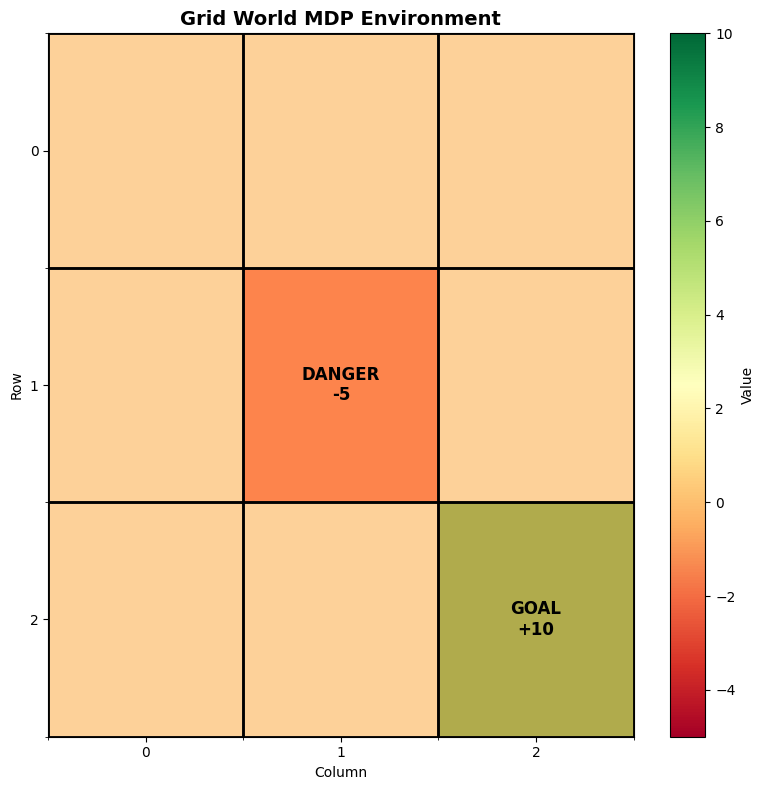

In [5]:
# Visualize the initial grid world
visualize_grid(env, title="Grid World MDP Environment")


### 2.5 Simulate Random Episodes

Let's simulate some random episodes to see how the agent behaves without a policy.


--- Simulating Random Episodes ---


Random Episode 1:
Random episode completed in 2 steps
Total reward: 10.00
Trajectory: [((2, 0), 'RIGHT'), ((2, 1), 'RIGHT')]


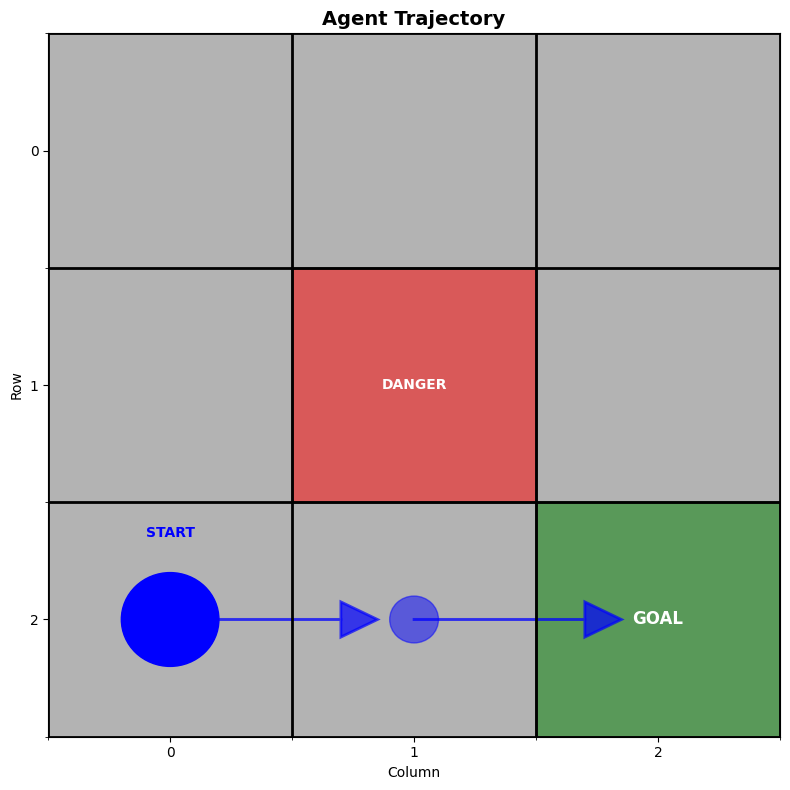


Random Episode 2:
Random episode completed in 2 steps
Total reward: 10.00
Trajectory: [((1, 1), 'RIGHT'), ((1, 2), 'DOWN')]

Random Episode 3:
Random episode completed in 20 steps
Total reward: -5.00
Trajectory: [((1, 1), 'DOWN'), ((2, 1), 'LEFT'), ((2, 1), 'LEFT'), ((2, 0), 'UP'), ((2, 0), 'RIGHT'), ((2, 1), 'LEFT'), ((2, 0), 'DOWN'), ((2, 1), 'RIGHT'), ((2, 0), 'UP'), ((1, 0), 'UP'), ((0, 0), 'RIGHT'), ((0, 1), 'UP'), ((0, 1), 'LEFT'), ((0, 0), 'LEFT'), ((0, 0), 'UP'), ((0, 0), 'DOWN'), ((1, 0), 'DOWN'), ((1, 1), 'UP'), ((0, 1), 'LEFT'), ((0, 2), 'UP')]


In [6]:
def simulate_random_episode(env: GridWorldMDP, max_steps: int = 20, visualize: bool = True):
    """
    Simulate a random episode (random actions).
    """
    start_state = random.choice([s for s in env.states if s != env.goal_state])
    state = start_state
    trajectory = []
    total_reward = 0

    for step in range(max_steps):
        if state == env.goal_state:
            break

        # Random action
        action = random.choice(env.actions)
        next_state, reward, done = env.step(state, action)
        trajectory.append((state, action, reward))
        total_reward += reward
        state = next_state

        if done:
            break

    print(f"Random episode completed in {len(trajectory)} steps")
    print(f"Total reward: {total_reward:.2f}")
    print(f"Trajectory: {[(s, a) for s, a, r in trajectory]}")

    if visualize:
        visualize_trajectory(env, trajectory)

    return trajectory, total_reward

# Simulate a few random episodes
print("--- Simulating Random Episodes ---\n")
for i in range(3):
    print(f"\nRandom Episode {i+1}:")
    simulate_random_episode(env, max_steps=20, visualize=(i == 0))


## Part 3: Implementing a Policy

### 3.1 Value Iteration Algorithm

Value Iteration computes the optimal value function V*(s) using the Bellman equation:

$$V(s) = \max_{a \in \mathcal{A}(s)} \sum_{s'} P(s'|s, a) [R(s,a,s') + \gamma V(s')]$$

For our stochastic environment:
- 80% of the time: agent transitions to the expected next state
- 20% of the time: agent randomly transitions to another state


In [7]:
def value_iteration(env: GridWorldMDP, theta: float = 1e-6, max_iterations: int = 1000):
    """
    Value Iteration algorithm.

    For each state s, updates:
    V(s) = max_a Σ P(s'|s,a) [R(s,a,s') + γ V(s')]

    Where:
    - 80% chance: intended action leads to expected next state
    - 20% chance: random action leads to random next state

    Args:
        env: GridWorldMDP environment
        theta: Convergence threshold
        max_iterations: Maximum number of iterations

    Returns:
        values: Optimal value function V*(s)
        policy: Optimal policy π*(s) -> action
    """
    # Initialize values to zero
    values = {state: 0.0 for state in env.states}

    for iteration in range(max_iterations):
        delta = 0
        new_values = {}

        for state in env.states:
            # Terminal state (goal): value is just the reward
            if state == env.goal_state:
                new_values[state] = env.reward_map[state]
                continue

            # For non-terminal states, compute Bellman update
            best_value = float('-inf')

            for action in env.actions:
                # Get all possible next states and their probabilities
                transition_probs = env.get_transition_probabilities(state, action)

                # Compute expected value for this action
                action_value = 0.0
                for next_state, prob in transition_probs.items():
                    reward = env.get_reward(state, action, next_state)
                    action_value += prob * (reward + env.discount_factor * values[next_state])

                best_value = max(best_value, action_value)

            new_values[state] = best_value
            delta = max(delta, abs(new_values[state] - values[state]))

        values = new_values

        # Check for convergence
        if delta < theta:
            print(f"Value iteration converged after {iteration + 1} iterations.")
            break

    # Extract optimal policy
    policy = {}
    for state in env.states:
        if state == env.goal_state:
            continue  # No action needed in terminal state

        best_action = None
        best_value = float('-inf')

        for action in env.actions:
            transition_probs = env.get_transition_probabilities(state, action)
            action_value = 0.0
            for next_state, prob in transition_probs.items():
                reward = env.get_reward(state, action, next_state)
                action_value += prob * (reward + env.discount_factor * values[next_state])

            if action_value > best_value:
                best_value = action_value
                best_action = action

        policy[state] = best_action

    return values, policy


In [8]:
# Run value iteration
print("--- Value Iteration ---\n")
values, policy = value_iteration(env)

# Print optimal values and policy
print("\nOptimal Values and Policy:")
print("-" * 60)
for i in range(env.grid_size):
    for j in range(env.grid_size):
        state = (i, j)
        if state in values:
            action = policy.get(state, 'N/A')
            print(f"State {state}: V*={values[state]:.4f}, π*={action}")
print("-" * 60)


--- Value Iteration ---

Value iteration converged after 23 iterations.

Optimal Values and Policy:
------------------------------------------------------------
State (0, 0): V*=12.3212, π*=DOWN
State (0, 1): V*=13.8424, π*=RIGHT
State (0, 2): V*=15.9442, π*=DOWN
State (1, 0): V*=13.8424, π*=DOWN
State (1, 1): V*=15.9490, π*=DOWN
State (1, 2): V*=18.1520, π*=DOWN
State (2, 0): V*=15.9442, π*=RIGHT
State (2, 1): V*=18.1520, π*=RIGHT
State (2, 2): V*=10.0000, π*=N/A
------------------------------------------------------------


### 3.3 Visualize Optimal Values and Policy


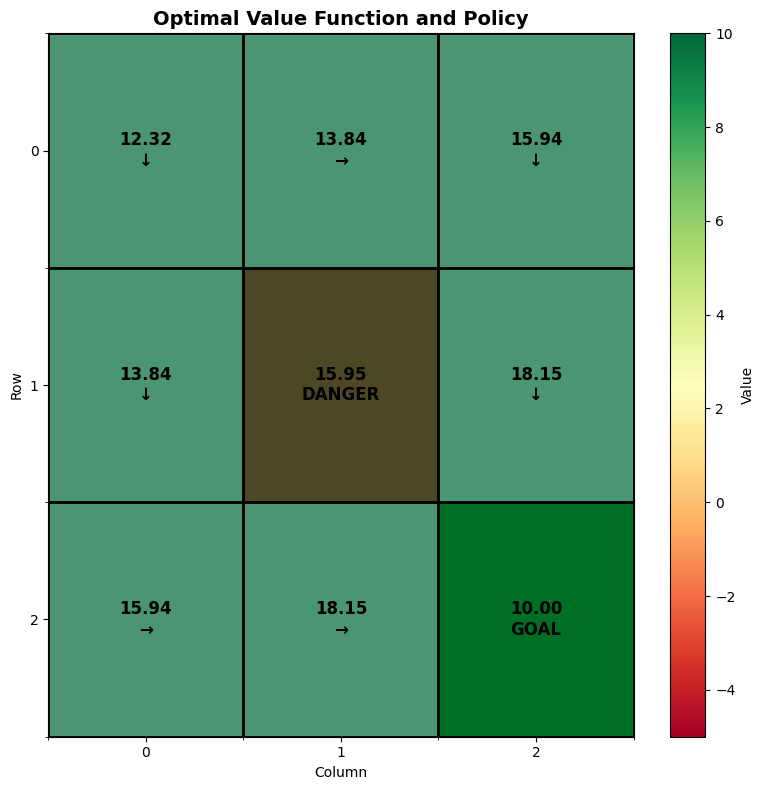

In [9]:
# Visualize optimal values and policy
visualize_grid(env, values=values, policy=policy,
              title="Optimal Value Function and Policy")


### 3.4 Simulate Policy Episodes

Now let's test the optimal policy by simulating episodes.


--- Simulating Policy-Driven Episodes ---


Policy Episode 1:
Episode completed in 2 steps
Total reward: 10.00
Trajectory: [((1, 1), 'DOWN'), ((2, 1), 'RIGHT')]


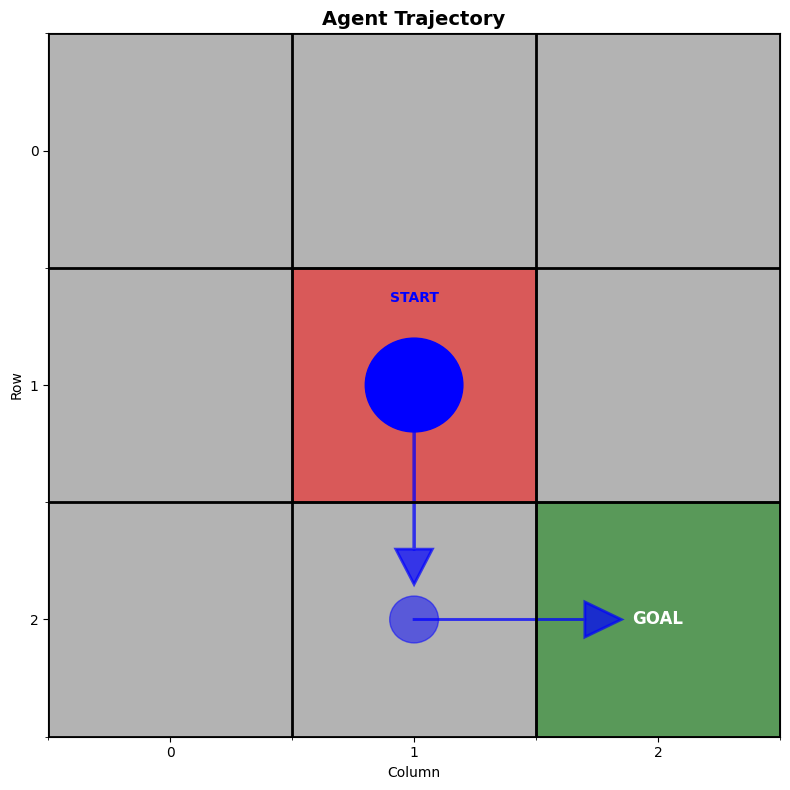


Policy Episode 2:
Episode completed in 4 steps
Total reward: 10.00
Trajectory: [((1, 0), 'DOWN'), ((1, 0), 'DOWN'), ((2, 0), 'RIGHT'), ((2, 1), 'RIGHT')]

Policy Episode 3:
Episode completed in 3 steps
Total reward: 10.00
Trajectory: [((1, 0), 'DOWN'), ((2, 0), 'RIGHT'), ((2, 1), 'RIGHT')]


In [10]:
def simulate_policy_episode(env: GridWorldMDP, policy: Dict[Tuple[int, int], str],
                           start_state: Optional[Tuple[int, int]] = None,
                           max_steps: int = 20, visualize: bool = True):
    """
    Simulate an episode following a given policy.

    Args:
        env: GridWorldMDP environment
        policy: Policy mapping states to actions
        start_state: Starting state (default: random non-terminal state)
        max_steps: Maximum number of steps
        visualize: Whether to visualize the trajectory

    Returns:
        trajectory: List of (state, action, reward) tuples
        total_reward: Total reward accumulated
    """
    # Choose starting state
    if start_state is None:
        non_terminal_states = [s for s in env.states if s != env.goal_state]
        start_state = random.choice(non_terminal_states)

    state = start_state
    trajectory = []
    total_reward = 0

    for step in range(max_steps):
        if state == env.goal_state:
            break

        # Get action from policy
        action = policy.get(state)
        if action is None:
            # If no policy for this state, choose random action
            action = random.choice(env.actions)

        # Take step
        next_state, reward, done = env.step(state, action)
        trajectory.append((state, action, reward))
        total_reward += reward
        state = next_state

        if done:
            break

    print(f"Episode completed in {len(trajectory)} steps")
    print(f"Total reward: {total_reward:.2f}")
    print(f"Trajectory: {[(s, a) for s, a, r in trajectory]}")

    if visualize:
        visualize_trajectory(env, trajectory)

    return trajectory, total_reward

# Simulate policy-driven episodes
print("--- Simulating Policy-Driven Episodes ---\n")
for i in range(3):
    print(f"\nPolicy Episode {i+1}:")
    simulate_policy_episode(env, policy, max_steps=20, visualize=(i == 0))


### 3.5 Performance Comparison

Let's compare the performance of random policy vs optimal policy over multiple episodes.


In [11]:
# Compare random vs policy performance
print("--- Performance Comparison ---\n")
print("Running 100 random episodes...")
random_rewards = []
for _ in range(100):
    _, reward = simulate_random_episode(env, max_steps=20, visualize=False)
    random_rewards.append(reward)

print("\nRunning 100 policy-driven episodes...")
policy_rewards = []
for _ in range(100):
    _, reward = simulate_policy_episode(env, policy, max_steps=20, visualize=False)
    policy_rewards.append(reward)

print(f"\n{'='*60}")
print("RESULTS SUMMARY")
print(f"{'='*60}")
print(f"\nRandom Policy:")
print(f"  Average reward: {np.mean(random_rewards):.2f}")
print(f"  Std deviation: {np.std(random_rewards):.2f}")
print(f"  Success rate: {sum(1 for r in random_rewards if r > 0) / len(random_rewards) * 100:.1f}%")

print(f"\nOptimal Policy:")
print(f"  Average reward: {np.mean(policy_rewards):.2f}")
print(f"  Std deviation: {np.std(policy_rewards):.2f}")
print(f"  Success rate: {sum(1 for r in policy_rewards if r > 0) / len(policy_rewards) * 100:.1f}%")
print(f"{'='*60}")


--- Performance Comparison ---

Running 100 random episodes...
Random episode completed in 20 steps
Total reward: 0.00
Trajectory: [((1, 1), 'RIGHT'), ((1, 2), 'DOWN'), ((0, 2), 'UP'), ((0, 2), 'LEFT'), ((0, 1), 'DOWN'), ((0, 2), 'LEFT'), ((0, 1), 'LEFT'), ((0, 0), 'UP'), ((0, 0), 'LEFT'), ((1, 0), 'UP'), ((0, 0), 'UP'), ((0, 0), 'LEFT'), ((0, 0), 'LEFT'), ((0, 0), 'UP'), ((0, 0), 'DOWN'), ((1, 0), 'UP'), ((0, 0), 'UP'), ((0, 0), 'DOWN'), ((1, 0), 'UP'), ((0, 0), 'LEFT')]
Random episode completed in 20 steps
Total reward: -5.00
Trajectory: [((0, 0), 'UP'), ((0, 0), 'DOWN'), ((1, 0), 'RIGHT'), ((1, 1), 'UP'), ((0, 1), 'RIGHT'), ((0, 2), 'LEFT'), ((0, 1), 'UP'), ((0, 1), 'LEFT'), ((0, 0), 'UP'), ((0, 0), 'UP'), ((0, 0), 'RIGHT'), ((0, 1), 'LEFT'), ((0, 2), 'DOWN'), ((1, 2), 'DOWN'), ((0, 2), 'DOWN'), ((0, 1), 'LEFT'), ((0, 0), 'RIGHT'), ((0, 1), 'UP'), ((0, 1), 'RIGHT'), ((0, 0), 'LEFT')]
Random episode completed in 9 steps
Total reward: -5.00
Trajectory: [((1, 1), 'DOWN'), ((2, 1), 'UP'

### 3.6 Visualize Performance Comparison


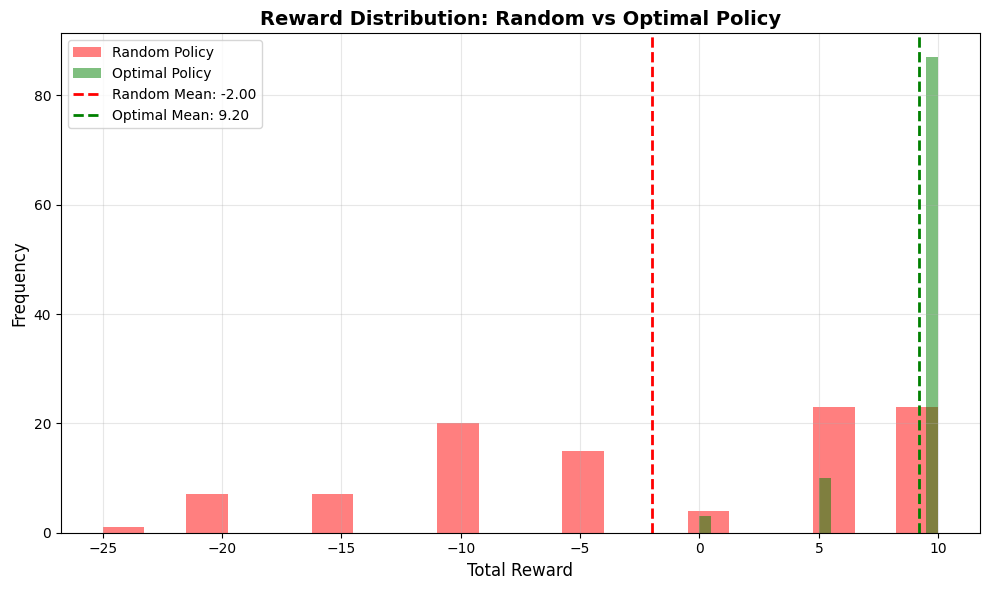

In [12]:
# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(random_rewards, bins=20, alpha=0.5, label='Random Policy', color='red')
ax.hist(policy_rewards, bins=20, alpha=0.5, label='Optimal Policy', color='green')
ax.axvline(np.mean(random_rewards), color='red', linestyle='--', linewidth=2,
           label=f'Random Mean: {np.mean(random_rewards):.2f}')
ax.axvline(np.mean(policy_rewards), color='green', linestyle='--', linewidth=2,
           label=f'Optimal Mean: {np.mean(policy_rewards):.2f}')
ax.set_xlabel('Total Reward', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Reward Distribution: Random vs Optimal Policy', fontsize=14, weight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Summary and Conclusions

### Key Findings:

1. **Value Iteration** successfully computed the optimal value function and policy for the 3×3 grid world MDP.

2. **Optimal Policy** significantly outperforms random policy:
   - Higher average rewards
   - More consistent performance (lower variance)
   - Higher success rate (reaching the goal)

3. **Stochastic Transitions** (80% intended, 20% random) make the problem more realistic and challenging, requiring the agent to account for uncertainty.

4. **Visualizations** help understand:
   - The value function shows expected long-term rewards
   - The policy arrows show optimal actions
   - Trajectories show actual agent behavior

### Deliverables Completed:

✅ Python implementation of GridWorldMDP environment  
✅ Value Iteration algorithm implementation  
✅ Policy simulation functions  
✅ Visualization of grid world, values, policies, and trajectories  
✅ Comparison between random and optimal policies  
✅ Documentation and comments explaining each step
